In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
df=pd.read_csv('Reviews.csv')

In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
df=df.head(100)

In [9]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

## Quick EDA

In [12]:
df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

Text(0.5, 0, 'count')

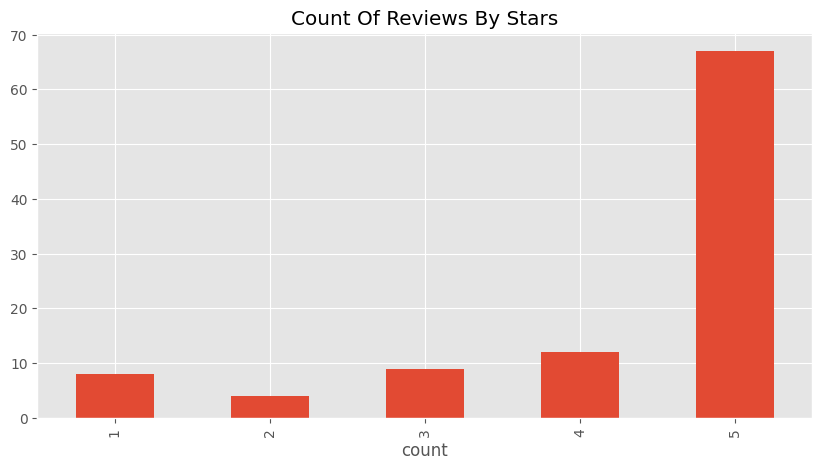

In [14]:
ax=df['Score'].value_counts().sort_index().plot(kind='bar',title='Count Of Reviews By Stars',figsize=(10,5))
ax.set_xlabel('count')

In [16]:
example=df['Text'].values[50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [18]:
tokens=nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [20]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [22]:
entities = nltk.chunk.ne_chunk(tagged)
entities[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

## Step-1 Vader Sentiment Scoring

In [25]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia= SentimentIntensityAnalyzer()

In [27]:
sia.polarity_scores('I am so Happy')

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [29]:
sia.polarity_scores('This is the worst thing ever')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [31]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [33]:
# Run the polarity on the entire dataset
res = {}
for i, row in tqdm(df.iterrows()):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

0it [00:00, ?it/s]

In [37]:
vaders = pd.DataFrame(res).T
vaders

,neg,neu,pos,compound
1,0.000,0.695,0.305,0.9441
2,0.138,0.862,0.000,-0.5664
3,0.091,0.754,0.155,0.8265
4,0.000,1.000,0.000,0.0000
5,0.000,0.552,0.448,0.9468
...,...,...,...,...
96,0.031,0.732,0.237,0.9273
97,0.000,0.818,0.182,0.9820
98,0.053,0.793,0.154,0.7729
99,0.024,0.910,0.066,0.5106


In [39]:
vaders = vaders.reset_index().rename(columns = {'index' : 'Id'})
vaders = vaders.merge(df, how = 'left')
vaders

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0.031,0.732,0.237,0.9273,B0019CW0HE,A1BFNM27629VAV,E. Triebe,0,0,5,1320105600,Good healthy dog food,I've been very pleased with the Natural Balanc...
96,97,0.000,0.818,0.182,0.9820,B0019CW0HE,A18AAABCIJKC5Q,Rhiever,0,0,5,1303776000,Great dog food,My 1-1/2 year old basenji/jack russell mix lov...
97,98,0.053,0.793,0.154,0.7729,B0019CW0HE,A3UII2114114PI,"FuNky Faja ""SiLkk""",0,0,5,1297296000,"Great allergy sensitive dog food, dogs love it",Our pup has experienced allergies in forms of ...
98,99,0.024,0.910,0.066,0.5106,B0019CW0HE,ABZ9F0D94YK45,Amazon-tron 3000,0,0,5,1295308800,Perfect for our English Bulldog with Allergies,My English Bulldog had skin allergies the summ...


In [41]:
# now we have sentimenet score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Text(0.5, 1.0, 'Compound Score by Amazon Star Review')

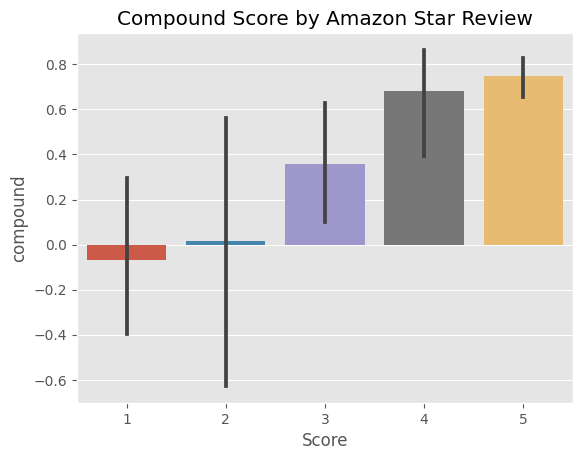

In [43]:
sns.barplot(x='Score',y='compound',data=vaders)
plt.title('Compound Score by Amazon Star Review')

Text(0.5, 1.0, 'negative')

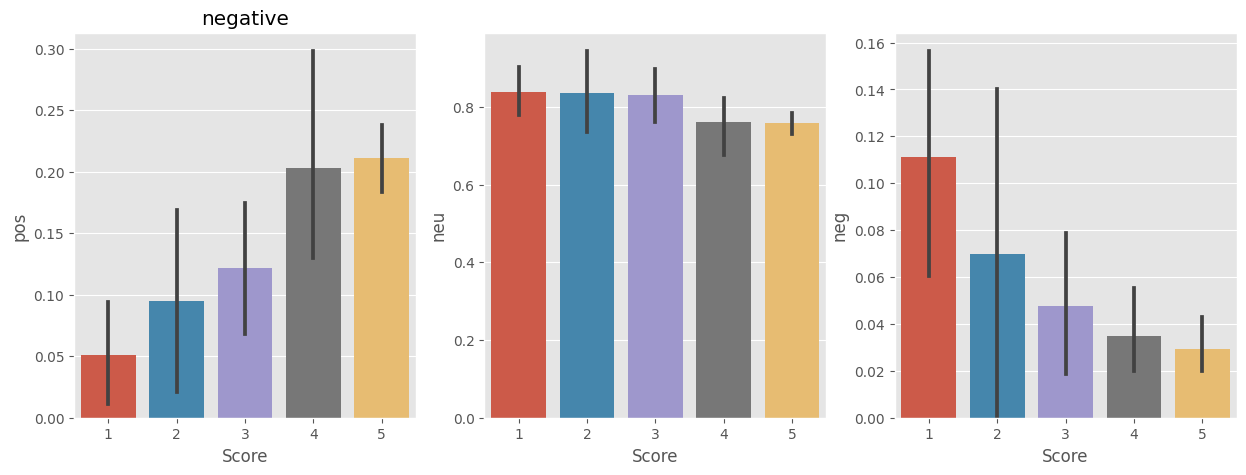

In [45]:
fig,axs=plt.subplots(1,3,figsize=(15,5))
sns.barplot(data=vaders,x='Score',y='pos' ,ax=axs[0])
sns.barplot(data = vaders, x = 'Score', y = 'neu',ax = axs[1])
sns.barplot(data = vaders, x = 'Score', y = 'neg',ax = axs[2])
axs[0].set_title('postive')
axs[0].set_title('neutral')
axs[0].set_title('negative')

## Step 2 Roberta Pretraied Model

In [48]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

C:\Users\peeth\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [49]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [50]:
# vader results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

### Run for roberta Model

In [55]:
encoded_text = tokenizer(example,return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687466, 'roberta_pos': 0.0029573692}


In [56]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example,return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [59]:

for i, row in tqdm(df.iterrows(),total = len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f'vader_{key}'] = value
    
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')
    

  0%|          | 0/100 [00:00<?, ?it/s]

Broke for id 83


In [60]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {'index' : 'Id'})
results_df = results_df.merge(df, how = 'left')

In [61]:
results_df = results_df.merge(df, how = 'left')

In [62]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,neg,neu,...,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,NaN,NaN,...,NaN,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,NaN,NaN,...,NaN,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,NaN,NaN,...,NaN,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,NaN,NaN,...,NaN,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,NaN,NaN,...,NaN,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Compare Scores Between Models

In [64]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'neg', 'neu', 'pos',
       'compound', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')

In [65]:
### Step 3 Combine And Compare

C:\Users\peeth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\peeth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\peeth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\peeth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length

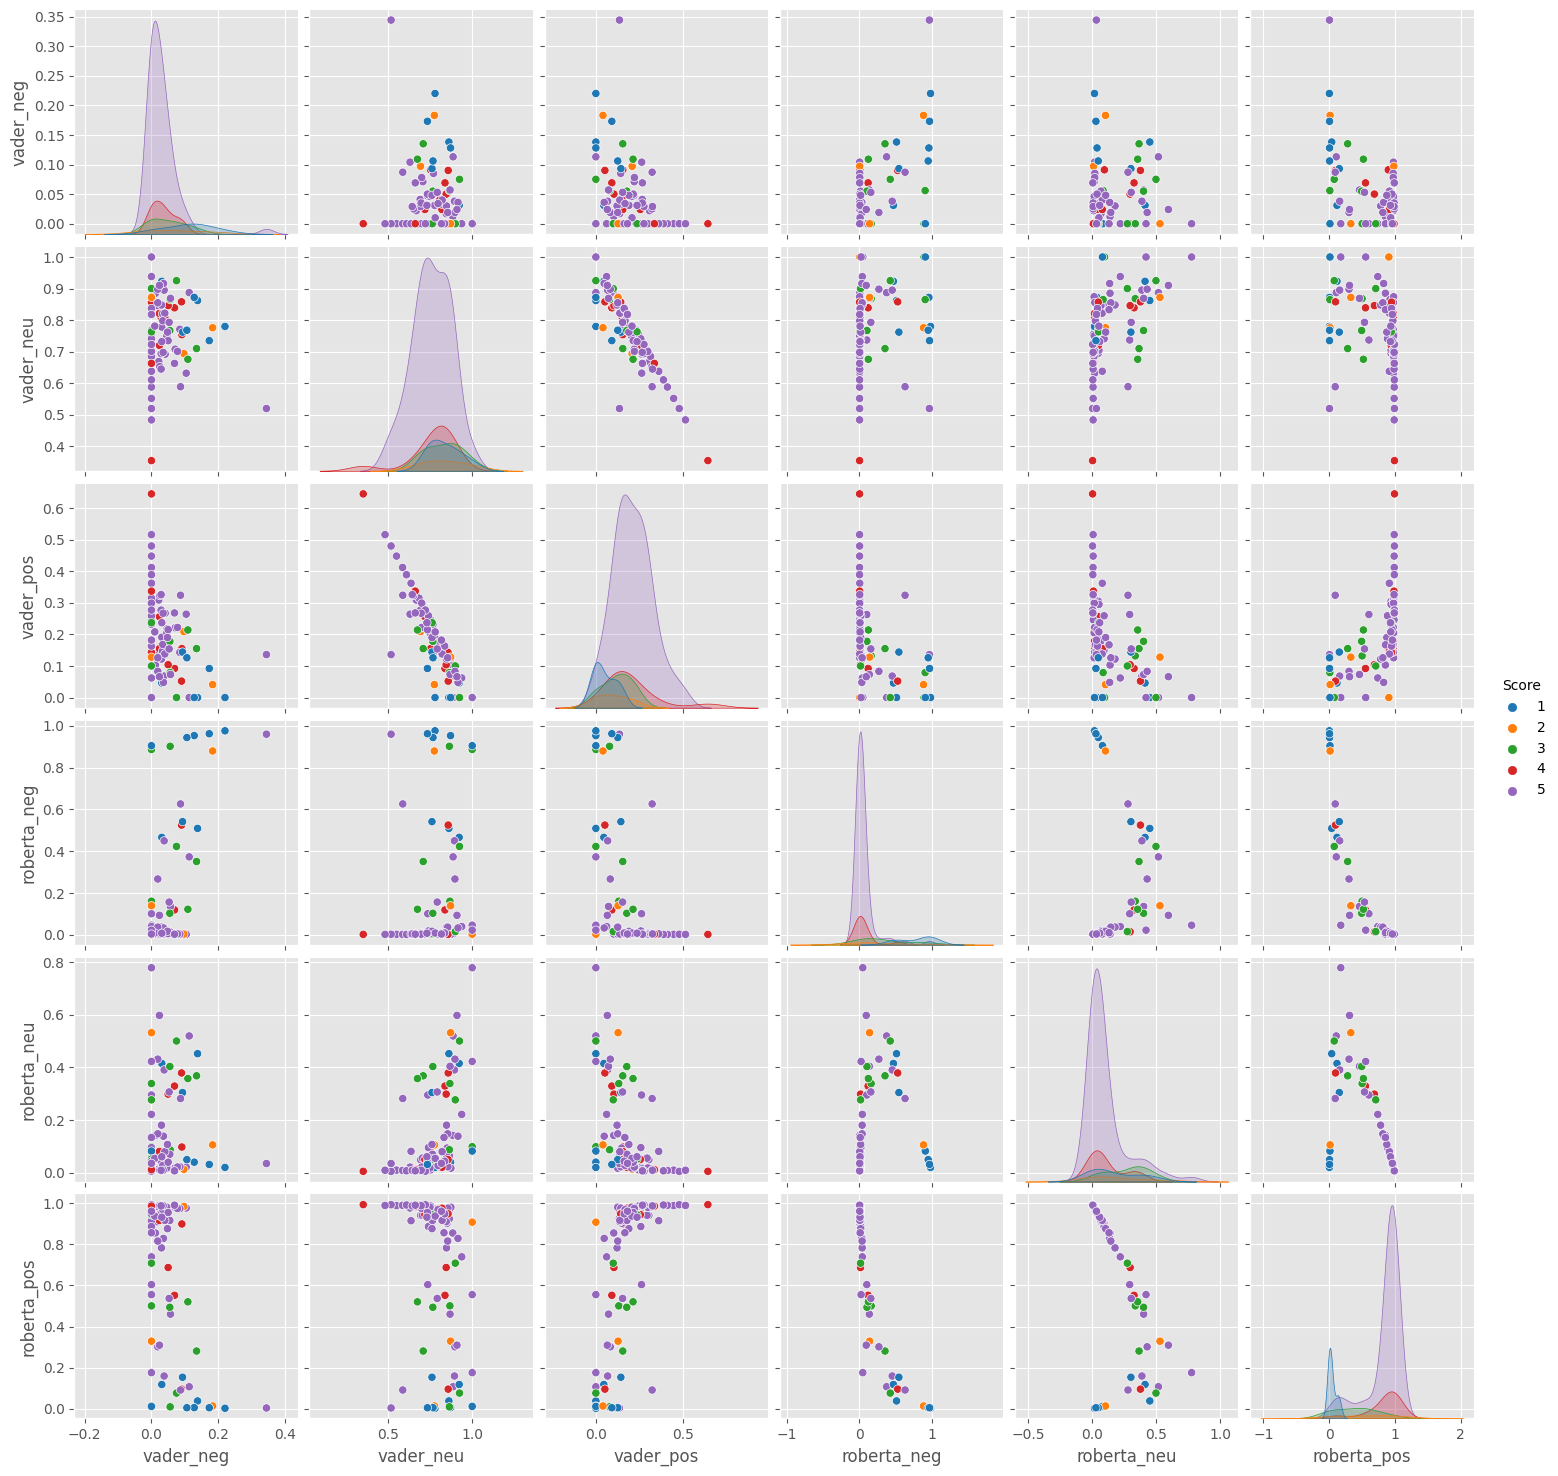

In [66]:
sns.pairplot(data = results_df,
             vars = ['vader_neg','vader_neu','vader_pos',
                    'roberta_neg','roberta_neu','roberta_pos'],
            hue = 'Score',
            palette = 'tab10')
plt.show()

### Review Examples:

Positive 1-star and Negative 5-star Reviews
Lets look at some examples where the model scoring and review score differ the most

In [69]:
results_df.query('Score == 1').sort_values('roberta_pos',ascending=False)['Text'].values[5]

'No tea flavor at all. Just whole brunch of artifial flavors. It is not returnable. I wasted 20+ bucks.'

In [70]:
results_df.query('Score == 1').sort_values('vader_pos',ascending=False)['Text'].values[5]

'The candy is just red , No flavor . Just  plan and chewy .  I would never buy them again'

In [71]:
# Negative Sentiment 5-Star Review

In [72]:
results_df.query('Score == 5').sort_values('roberta_neg',ascending=False)['Text'].values[1]

'i know i cannot make tea this good.  granted, i am not from the south but i know i have never enjoyed tea that was this sweet without being too sweet.  it tastes crisp.'

In [73]:
results_df.query('Score == 5').sort_values('vader_neg',ascending=False)['Text'].values[7]

'This food is great - all ages dogs.  I have a 3 year old and a puppy.  They are both so soft and hardly ever get sick.  The food is good especially when you have Amazon Prime shipping  :)'

## Quick And Easy to run sentiment predictions

In [75]:
# Below Lib gives us a function for which we can directly use sentiment analysis by text

In [76]:
from transformers import pipeline

sent_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [77]:
sent_pipeline('I hate Sentiment Analysis')

[{'label': 'NEGATIVE', 'score': 0.9991728663444519}]